## SHUBHAM SHIV JOSHI
## ROLL NO: 200970
## IIT KANPUR
# Importing suitable Libraries and Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Downloading and making Dataset ready
### We used a  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz dataset loaded from PyTorch datasets. Later it is tradtionally split into training, validation and test datasets and defined their corresponding dataloaders.

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:03<00:00, 47533064.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Initializing the CNN Model
### Used the pre-trained VGG-19 model to train on the dataset as it performs well in neural style transfer tasks.

In [3]:
# Load pre-trained VGG19 model
vgg19 = torchvision.models.vgg19(pretrained=True)

# Modify the last fully connected layer for CIFAR-10 (10 classes)
vgg19.classifier[6] = nn.Linear(4096, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Model Training and Evaluation
###  The model undergoes training for 10 epochs on the training set, assessing accuracy on the validation set at the conclusion of each epoch. The ultimate step involves gauging accuracy on the test set, aiding in the determination of optimal hyperparameters to achieve maximum overall accuracy.

In [4]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    vgg19.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")

    # Validation loop
    vgg19.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg19(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100 * correct / total}%")

# Testing loop
vgg19.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total}%")

Epoch 1/10, Training Loss: 1.1678805611604317
Epoch 1/10, Validation Loss: 0.9536545027660418, Validation Accuracy: 65.96%
Epoch 2/10, Training Loss: 0.8424069065261971
Epoch 2/10, Validation Loss: 0.8198554994939249, Validation Accuracy: 71.44%
Epoch 3/10, Training Loss: 0.7288508958352561
Epoch 3/10, Validation Loss: 0.7290927820567843, Validation Accuracy: 74.06%
Epoch 4/10, Training Loss: 0.6702892609279264
Epoch 4/10, Validation Loss: 0.7078567848929876, Validation Accuracy: 74.8%
Epoch 5/10, Training Loss: 0.6207746824842285
Epoch 5/10, Validation Loss: 0.637021978444691, Validation Accuracy: 78.26%
Epoch 6/10, Training Loss: 0.5807703905315562
Epoch 6/10, Validation Loss: 0.607968881726265, Validation Accuracy: 78.94%
Epoch 7/10, Training Loss: 0.5512266757432371
Epoch 7/10, Validation Loss: 0.5822610856988762, Validation Accuracy: 79.38%
Epoch 8/10, Training Loss: 0.521348418244584
Epoch 8/10, Validation Loss: 0.6190648130789588, Validation Accuracy: 78.78%
Epoch 9/10, Training

# Saving the model

In [10]:
torch.save(vgg19.state_dict(), 'vgg19_model.pth')

# Defining the function for Style Transfer and making the similar art
### Loading and preprocessing content and style images, then transferring them to the specified device.
### Calculating the Gram matrix for a set of image features using the gram_matrix function.
### Defining style weight coefficients for different layers within the style_wt_meas dictionary.
### Extracting style and content features from the VGG19 model.
### Computing Gram matrices for style representation across various layers.

In [13]:
def stylize_image(style_path, content_path):

    # Load the VGG19 model's features
    vgg19 = torchvision.models.vgg19()
    vgg19.classifier[6] = nn.Linear(4096, 10)
    vgg19.load_state_dict(torch.load('vgg19_model.pth'))
    vgg19.eval()
    model = vgg19.features

    # Freeze model parameters
    for p in model.parameters():
        p.requires_grad = False

    # Move the model to the selected device
    model.to(device)

    # Define a function to extract model activations
    def model_activations(input, model):
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }
        features = {}
        x = input.unsqueeze(0)
        for name, layer in model._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

    # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize(300),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load and preprocess content and style images
    content = Image.open(content_path).convert("RGB")
    content = transform(content).to(device)
    print("Content shape:", content.shape)

    style = Image.open(style_path).convert("RGB")
    style = transform(style).to(device)

    # Clone content for the target and enable gradients
    target = content.clone().requires_grad_(True).to(device)


    def gram_matrix(img_feature):
      _, d, h, w = img_feature.size()
      img_feature = img_feature.view(d, h * w)
      gram_mat = torch.mm(img_feature, img_feature.t())
      return gram_mat

    # Define style weight measurements
    style_wt_meas = {
        "conv1_1": 0.2,
        "conv2_1": 0.2,
        "conv3_1": 0.2,
        "conv4_1": 0.2,
        "conv5_1": 0.2
    }

    # Compute style Gram matrices
    style_features = model_activations(style, model)
    content_features = model_activations(content, model)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # Set content and style weights
    content_wt = 0.05
    style_wt = 1e5

    epochs = 5000
    optimizer = torch.optim.Adam([target], lr=0.007)

    def imcnvt(image):
      x = image.to("cpu").clone().detach().numpy().squeeze()
      x = x.transpose(1, 2, 0)
      x = x * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
      return np.clip(x, 0, 1)

    # Define a function to display the image
    def display_image(image, title=None):
        image = imcnvt(image)
        plt.imshow(image)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()

    print_every = 1000

     # Training loop
for epoch in range(1, epochs + 1):
    # Forward pass to compute features
    target_features = model_activations(target, model)
    content_loss = torch.mean(torch.square(content_features['conv4_2'] - target_features['conv4_2']))

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _, d, w, h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (
            style_wt_meas[layer] * torch.mean(torch.square(target_gram - style_gram))) / (d * w * h)

    total_loss = content_wt * content_loss + style_wt * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display content, style, and final image side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Display content image
    ax1.imshow(imcnvt(content))
    ax1.set_title('Content')
    ax1.axis('off')

    # Display style image
    ax2.imshow(imcnvt(style))
    ax2.set_title('Style')
    ax2.axis('off')

    # Display final image
    ax3.imshow(imcnvt(target))
    ax3.set_title('Final Image')
    ax3.axis('off')

    plt.show()

# Examples

Content shape: torch.Size([3, 300, 533])


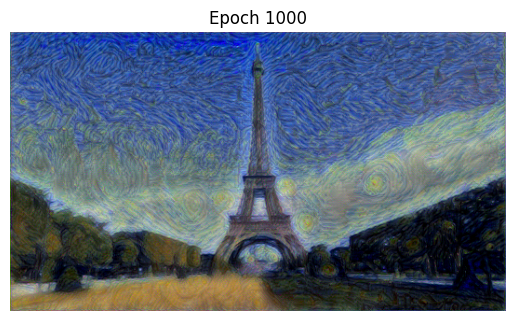

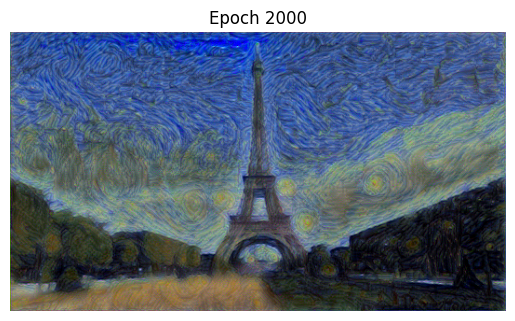

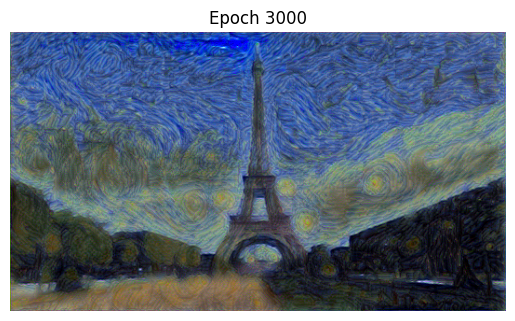

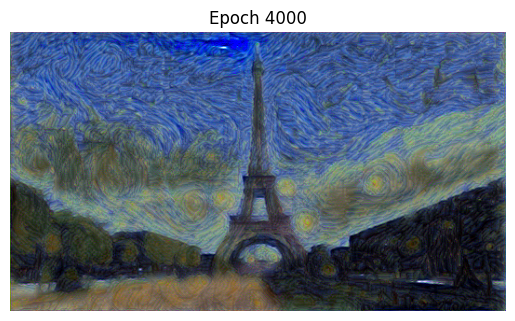

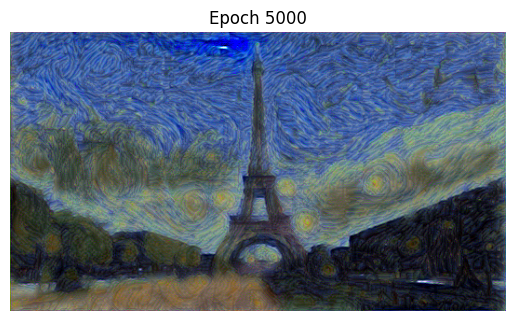

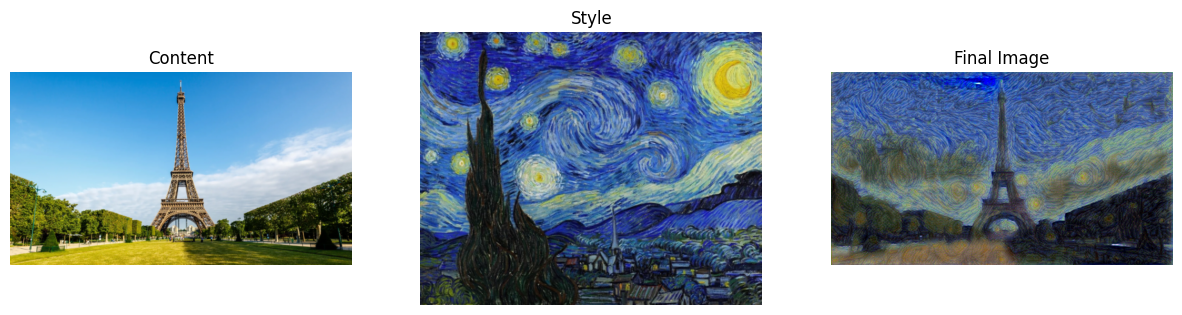

In [14]:
stylize_image("style1.jpg", "content1.jpg")

Content shape: torch.Size([3, 300, 450])


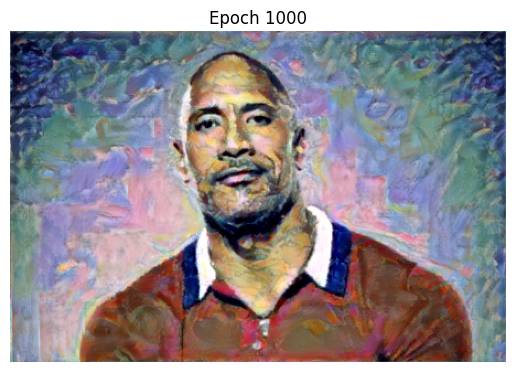

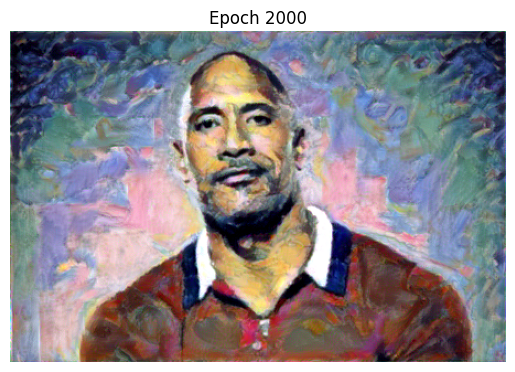

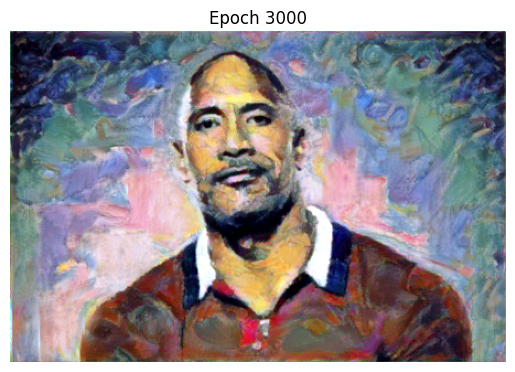

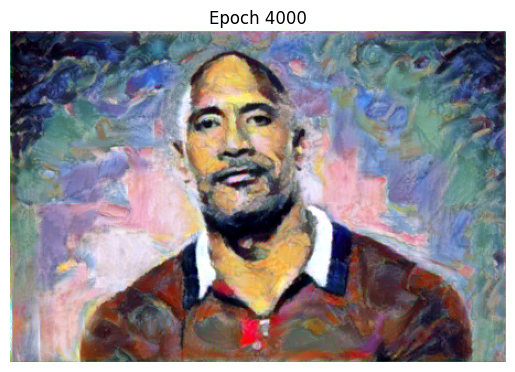

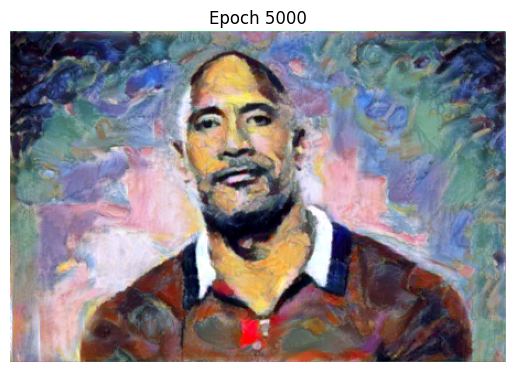

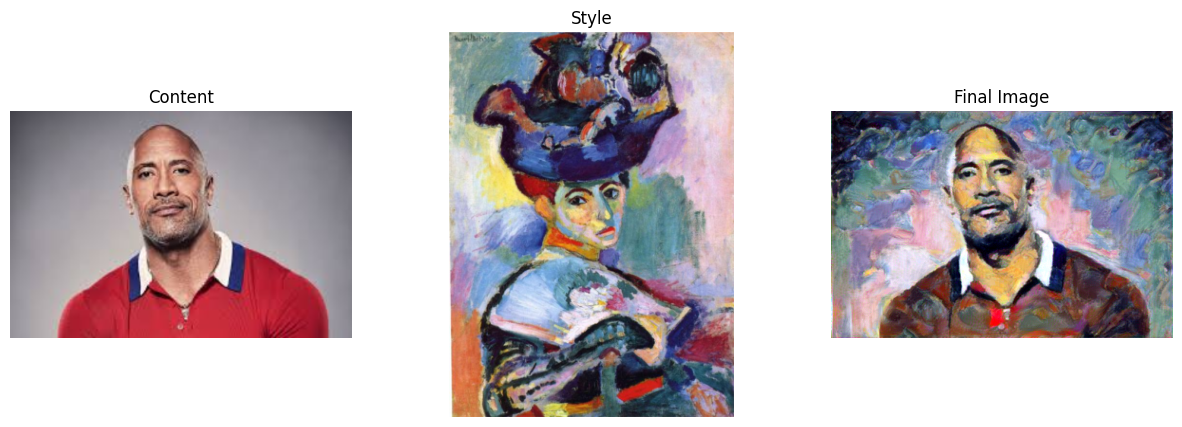

In [15]:
stylize_image("style2.jpg", "content2.jpeg")

Content shape: torch.Size([3, 300, 300])


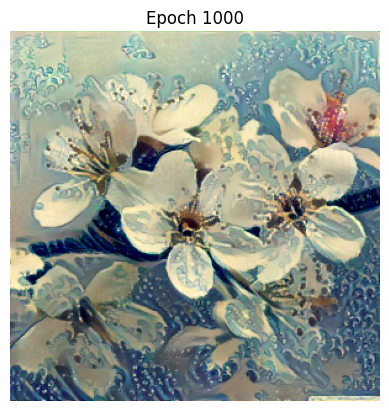

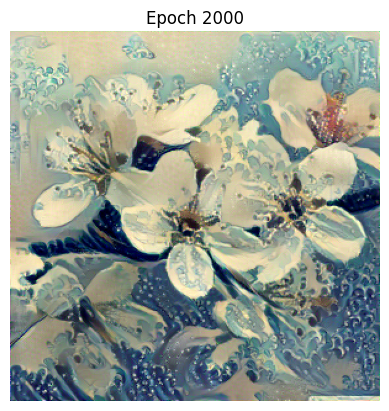

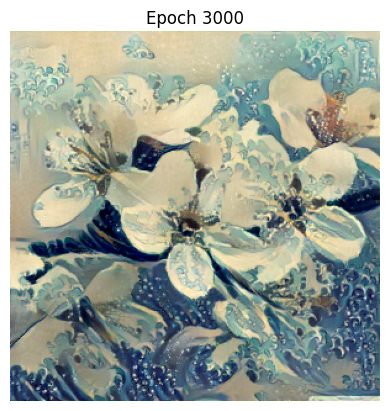

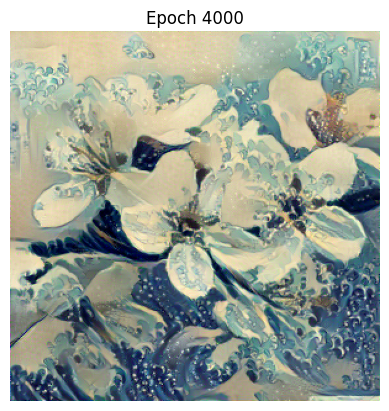

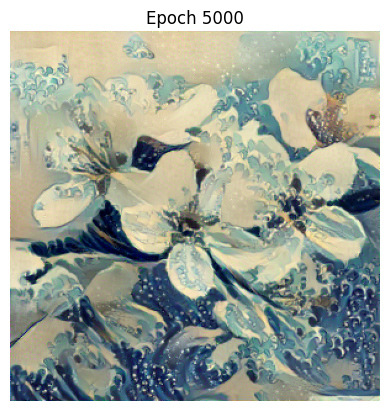

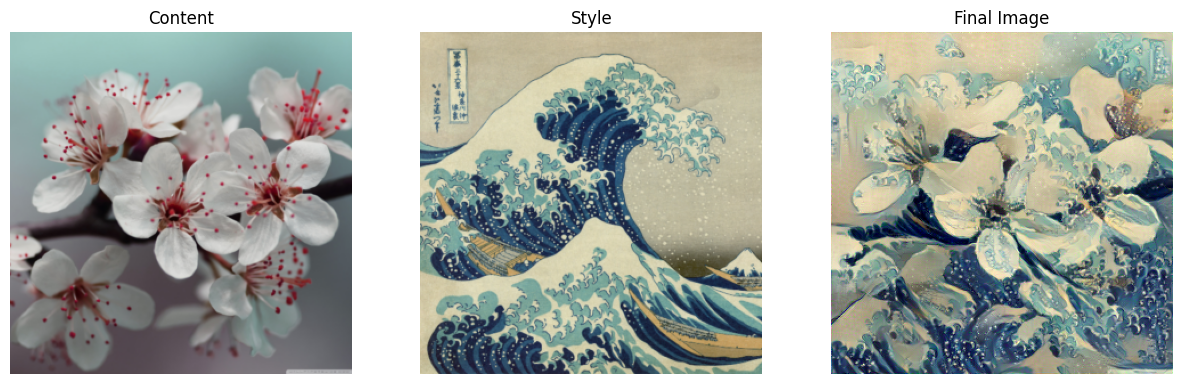

In [9]:
stylize_image("style3.png", "content3.jpg")

# Conslusion and observations

### -When the content and style images depict similar subjects, such as portraits (as in example 2), the style transfer outcome is notably more visually appealing.

### -Conversely, if the images used are highly disparate (as in example 3), the resulting image tends to lose its visual charm, resembling more of an image overlay than a genuine style transfer.

### -Potential solutions for these challenges include employing an even larger model or utilizing a model specifically trained on artistic images.

### -The utilization of a pretrained model yielded significantly superior results when compared to a model trained from scratch.

### -The model was time consuming and bulky consuming huge amount of resources, one way to tackle is to reduce the number of workers in loading dataset

